In [1]:
%matplotlib inline

import os

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy.ndimage.filters import gaussian_filter

from plotting import plot_circular_histogram

DATA = "data/fig12-optimisation"
THALAMUS_DATA = "data/fig3-thalamus_bifurcation"
ALN_DATA = "data/fig4-aln_bifurcation"

DPI = 75
CMAP = "plasma"
plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")


def norm_ou_mu(da):
    da["ou_exc_mu"] = da["ou_exc_mu"] / 5.0
    da["ou_inh_mu"] = da["ou_inh_mu"] / 5.0
    return da

In [2]:
# https://stackoverflow.com/a/47664533
class SeabornFig2Grid:
    def __init__(self, seaborngrid, fig, subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or isinstance(
            self.sg, sns.axisgrid.PairGrid
        ):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n, m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i, j], self.subgrid[i, j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h = self.sg.ax_joint.get_position().height
        h2 = self.sg.ax_marg_x.get_position().height
        r = int(np.round(h / h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(
            r + 1, r + 1, subplot_spec=self.subplot
        )

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        # https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure = self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


def plot_single_jointgrid(x, y, data):
    g = sns.JointGrid(data=data, x=x["key"], y=y["key"], xlim=x["lim"], ylim=y["lim"])
    g.set_axis_labels(xlabel=x["label"], ylabel=y["label"])
    g.plot_joint(
        sns.scatterplot,
        hue=data["f0"],
        palette=CMAP,
        size=data["f1"] ** 2,
        alpha=0.7,
        zorder=10,
    )
    g.ax_joint.legend_.remove()
    g.plot_marginals(sns.histplot, kde=True, color="C0", edgecolor="none")
    return g

In [3]:
opt_df = pd.read_csv(os.path.join(DATA, "optimisation_selection.csv"), index_col=0)

In [4]:
# prepare thalamic bifurcation
spindles_xr = xr.open_dataarray(os.path.join(THALAMUS_DATA, "spindles_detection_trn_thresh.nc"))
coords = {
    "g_LK": list(set(spindles_xr["g_h"].values) - set(spindles_xr["g_LK"].values)),
    "g_h": spindles_xr["g_h"].values,
    "tcr_noise": spindles_xr["tcr_noise"].values,
}
dims = coords.keys()
add_df = xr.DataArray(0.0, dims=dims, coords=coords)
spindles_xr = xr.concat([add_df, spindles_xr], dim="g_LK").sortby("g_LK")

In [5]:
# prepare ALN bifurcation
adex_maxE = xr.open_dataarray(os.path.join(ALN_DATA, "adex_maxE.nc")) * 1000
adex_maxE = norm_ou_mu(adex_maxE)

adex_domfr = xr.open_dataarray(os.path.join(ALN_DATA, "adex_domfr.nc")).isel(
    {"time": 0}
)
adex_domfr = norm_ou_mu(adex_domfr)

FR_THRESH = 0.5

/Users/nikola/.virtualenvs/paper_thlm_aln/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: No contour levels were found within the data range.
/Users/nikola/.virtualenvs/paper_thlm_aln/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


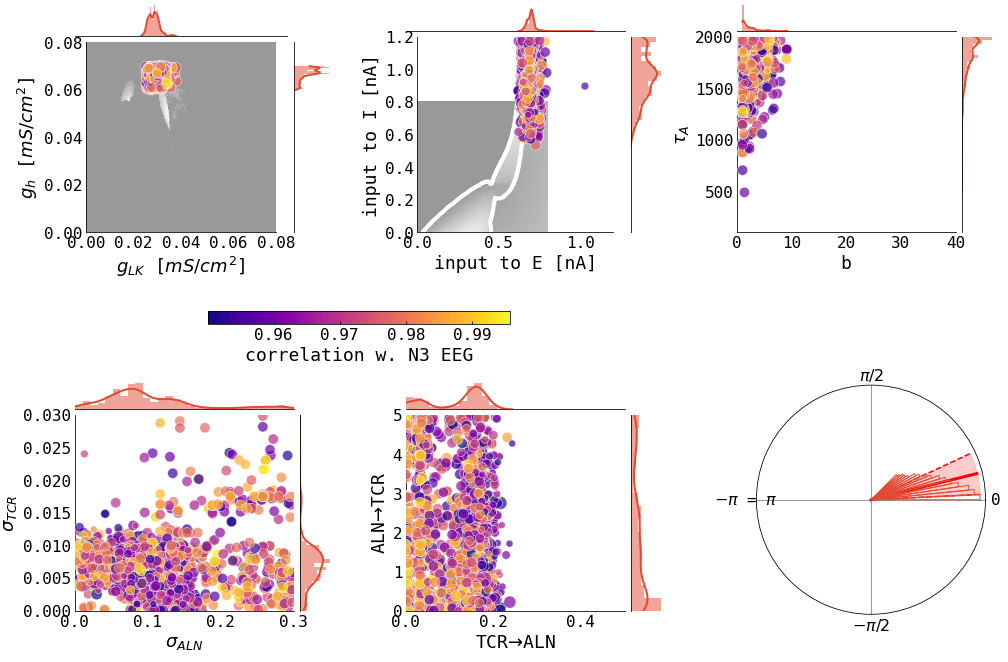

In [6]:
g1 = plot_single_jointgrid(
    {"key": "*g_LK", "label": "$g_{LK}$ [$mS/cm^2$]", "lim": [0.0, 0.08]},
    {"key": "*g_h", "label": "$g_{h}$ [$mS/cm^2$]", "lim": [0.0, 0.08]},
    opt_df,
)
f = spindles_xr.sel({"tcr_noise": 0.0}).values
f[np.isnan(f)] = 0.0
g1.ax_joint.imshow(
    f.T,
    cmap="gray",
    origin="lower",
    alpha=0.4,
    extent=[
        spindles_xr["g_LK"].min(),
        spindles_xr["g_LK"].max(),
        spindles_xr["g_h"].min(),
        spindles_xr["g_h"].max(),
    ],
)

g2 = plot_single_jointgrid(
    {"key": "*ALN*EXC*noise*mu", "label": "input to E [nA]", "lim": [0.0, 1.2]},
    {"key": "*ALN*INH*noise*mu", "label": "input to I [nA]", "lim": [0.0, 1.2]},
    opt_df,
)
g2.ax_joint.imshow(
    adex_maxE.sel({"ou_sigma": 0.0}).values.T,
    cmap="gray",
    origin="lower",
    vmin=0.0,
    vmax=np.nanmax(adex_maxE.values),
    extent=[
        adex_maxE["ou_exc_mu"].min(),
        adex_maxE["ou_exc_mu"].max(),
        adex_maxE["ou_inh_mu"].min(),
        adex_maxE["ou_inh_mu"].max(),
    ],
    alpha=0.4,
)
blurred = gaussian_filter(adex_domfr.sel({"ou_sigma": 0.0}).values, 0.0)
blurred[blurred < FR_THRESH] = 0
blurred[blurred >= FR_THRESH] = 1
xi, yi = np.meshgrid(adex_maxE["ou_exc_mu"], adex_maxE["ou_inh_mu"])
g2.ax_joint.contour(
    xi,
    yi,
    blurred.T,
    colors="white",
    linestyles="solid",
    levels=[0, 1.0001],
    linewidths=(4,),
    zorder=1,
)

g3 = plot_single_jointgrid(
    {"key": "*ALN*b", "label": "b", "lim": [0, 40]},
    {"key": "*ALN*tauA", "label": r"$\tau_{A}$", "lim": [100, 2000]},
    opt_df,
)
g4 = plot_single_jointgrid(
    {"key": "*ALNNode*noise*sigma", "label": r"$\sigma_{ALN}$", "lim": [0, 0.3]},
    {"key": "*TCR*noise*sigma", "label": r"$\sigma_{TCR}$", "lim": [0, 0.03]},
    opt_df,
)
g5 = plot_single_jointgrid(
    {"key": "thal_aln", "label": r"TCR$\to$ALN", "lim": [0, 0.5]},
    {"key": "aln_thal", "label": r"ALN$\to$TCR", "lim": [0, 5.0]},
    opt_df,
)

fig = plt.figure(figsize=(14, 9.3))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.15, 1])

for i in range(3):
    ax = fig.add_subplot(gs[1, i])
    ax.axis("off")

mg1 = SeabornFig2Grid(g1, fig, gs[0, 0])
mg2 = SeabornFig2Grid(g2, fig, gs[0, 1])
mg3 = SeabornFig2Grid(g3, fig, gs[0, 2])
mg4 = SeabornFig2Grid(g4, fig, gs[2, 0])
mg5 = SeabornFig2Grid(g5, fig, gs[2, 1])
ax = fig.add_subplot(gs[2, 2], projection="polar")
plot_circular_histogram(opt_df["f2"].dropna(), ax=ax)

cbar_ax = fig.add_axes([0.2, 0.51, 0.3, 0.02])
cbar = mpl.colorbar.ColorbarBase(
        cbar_ax,
        cmap=plt.get_cmap(CMAP),
        norm=mpl.colors.Normalize(vmin=opt_df["f0"].min(), vmax=opt_df["f0"].max()),
        orientation="horizontal",
    )
cbar.set_label("correlation w. N3 EEG")

gs.tight_layout(fig)

# to PDF due transparency
plt.savefig("../figs/optimisation.pdf", dpi=DPI, transparent=True, bbox_inches="tight")

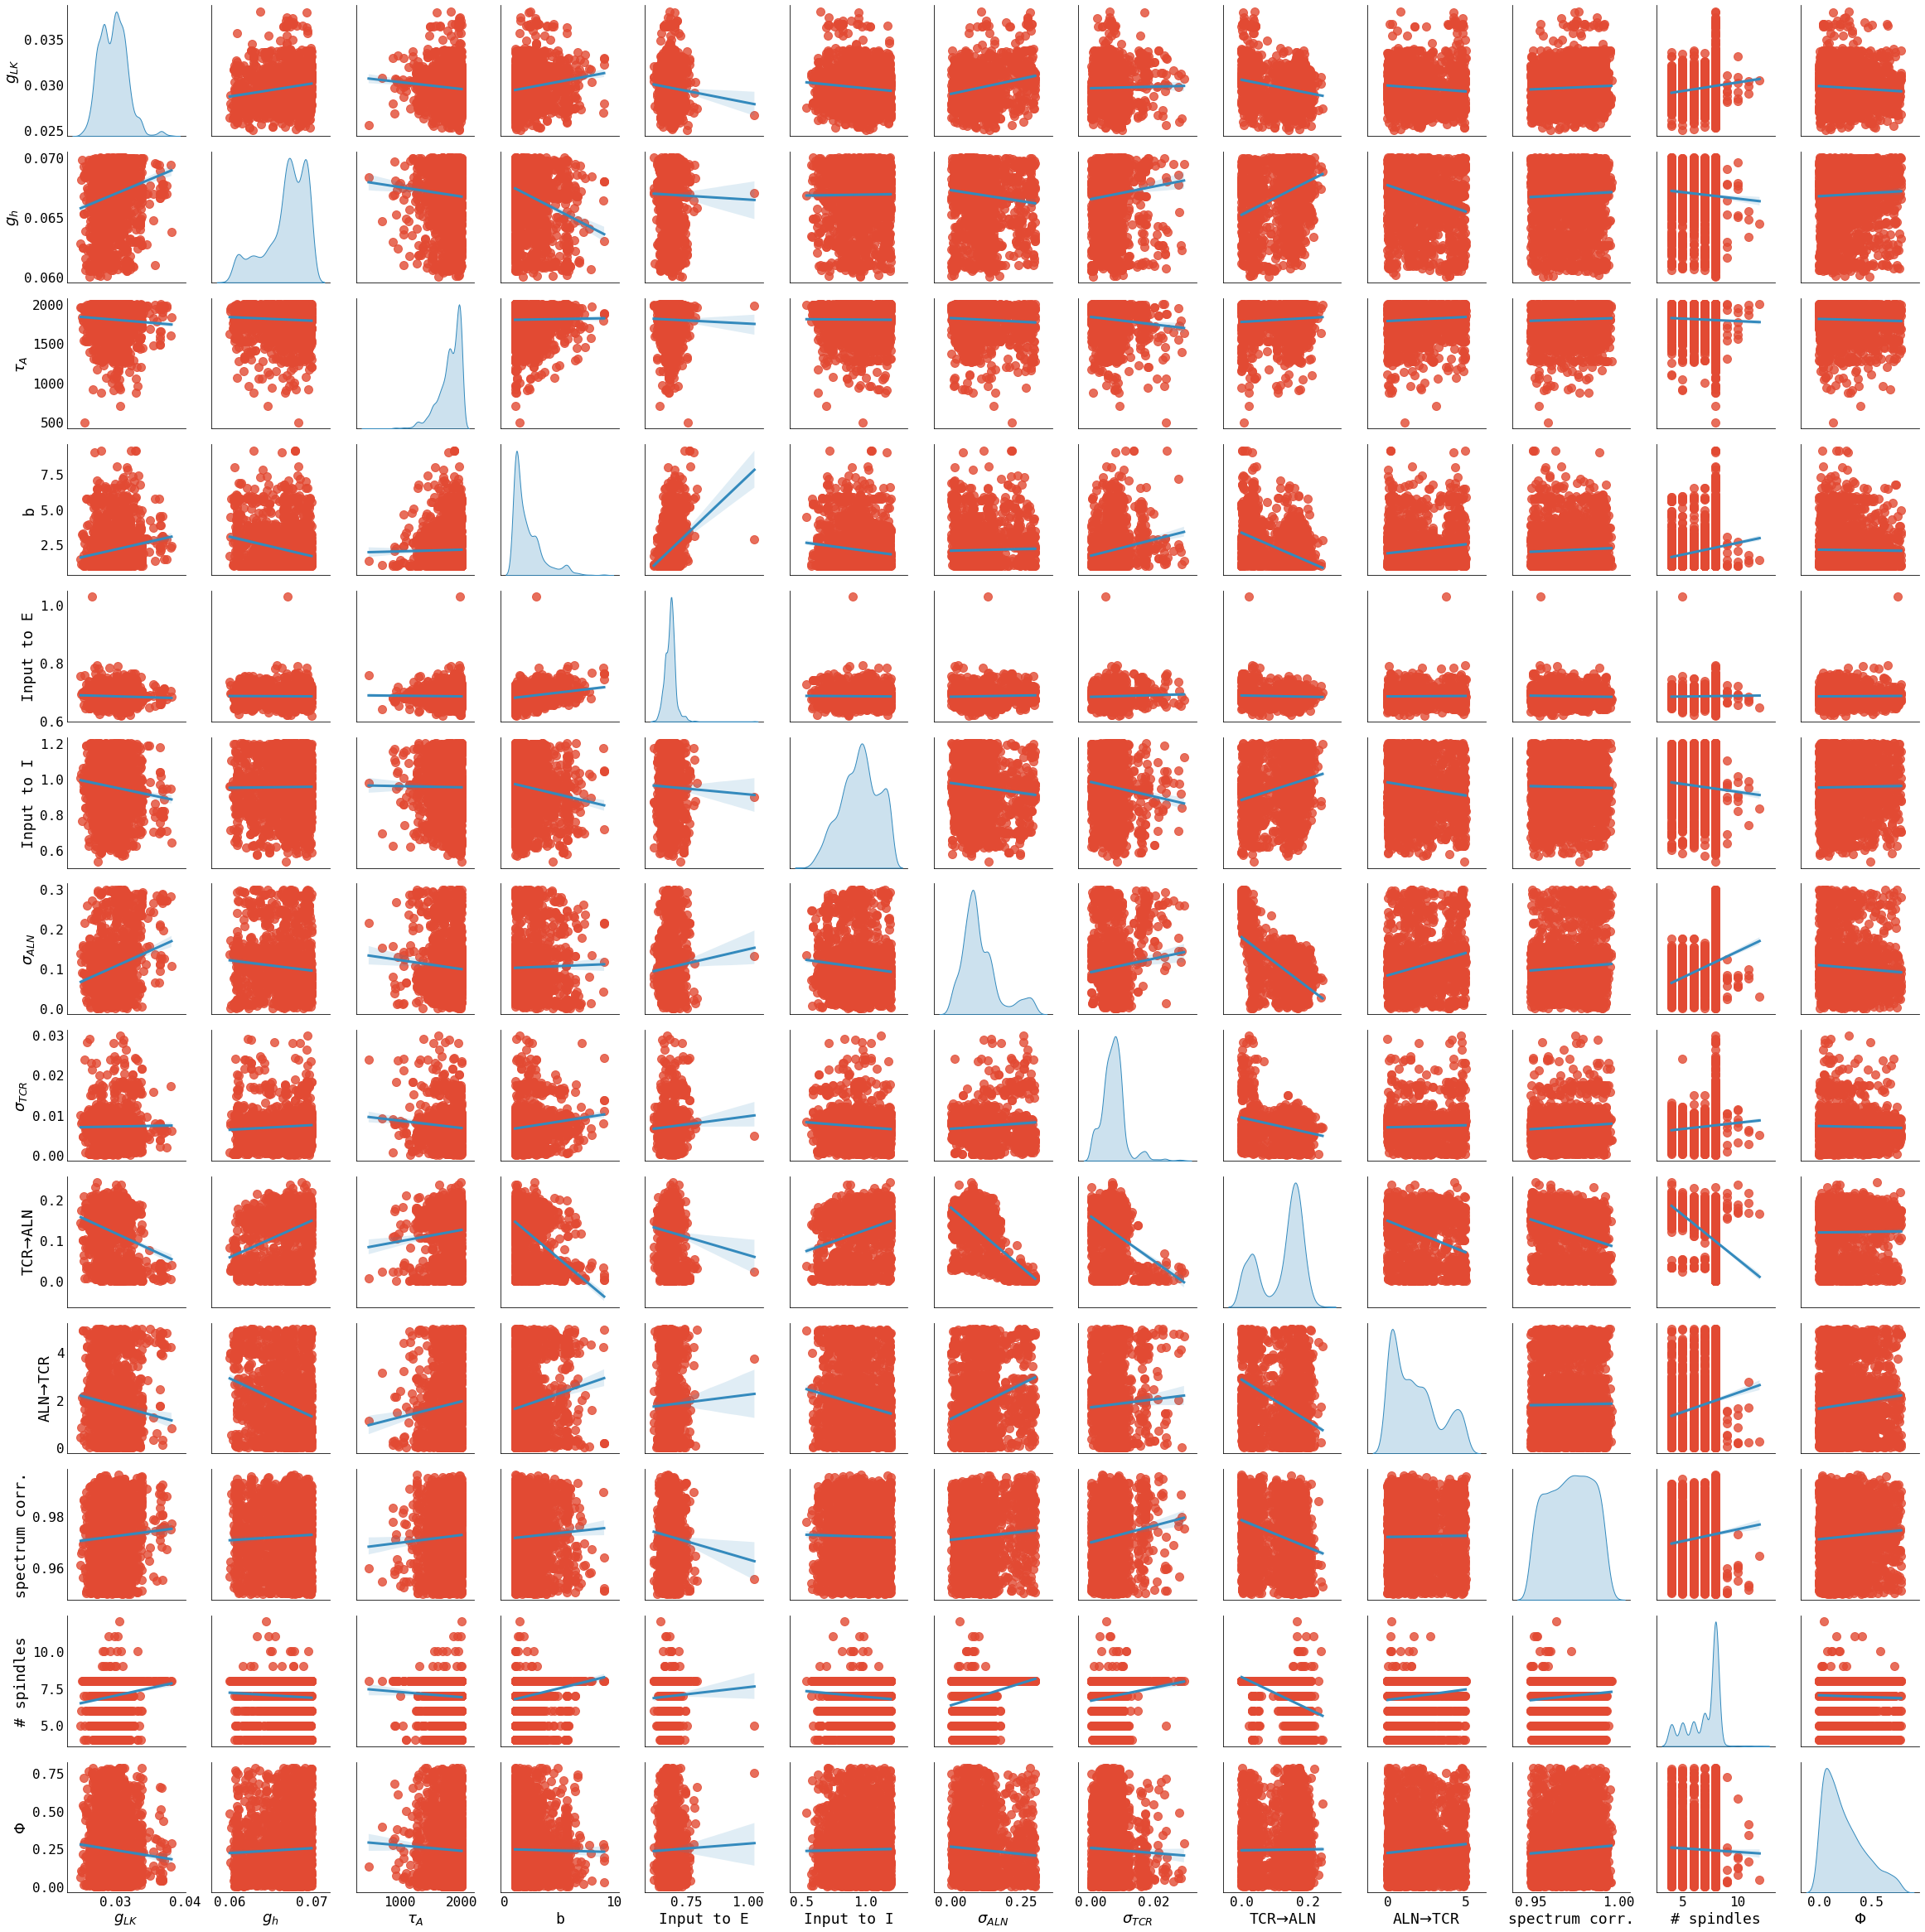

In [17]:
sns.pairplot(
    opt_df.drop(
        ["score", "id", "gen"], axis=1
    ).rename(
        {
            "*g_LK": "$g_{LK}$",
            "*g_h": "$g_{h}$",
            "*ALN*tauA": r"$\tau_{A}$",
            "*ALN*b": "b",
            "*ALN*EXC*noise*mu": "Input to E",
            "*ALN*INH*noise*mu": "Input to I",
            "*ALNNode*noise*sigma": "$\sigma_{ALN}$",
            "*TCR*noise*sigma": "$\sigma_{TCR}$",
            "thal_aln": r"TCR$\to$ALN",
            "aln_thal": r"ALN$\to$TCR",
            "f0": "spectrum corr.",
            "f1": "# spindles",
            "f2": "$\Phi$",
        },
        axis=1,
    ),
    diag_kws=dict(color="C1"),
    kind="reg",
    diag_kind="kde",
    plot_kws={"line_kws": {"color": "C1"}},
)

plt.tight_layout()

# to PDF due transparency
plt.savefig(
    "../figs/optimisation_pairs.png", dpi=DPI, transparent=True, bbox_inches="tight"
)